In [1]:
!wget https://cdn.pixabay.com/photo/2017/07/31/07/58/dog-2556796_960_720.jpg

--2021-05-05 17:30:36--  https://cdn.pixabay.com/photo/2017/07/31/07/58/dog-2556796_960_720.jpg
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.20.183, 104.18.21.183, 2606:4700::6812:15b7, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.20.183|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [2]:
import jax
from jax import numpy as jnp
from jax.experimental import stax
from functools import partial
from tqdm import tqdm
import numpy as np

rng = jax.random.PRNGKey(42)

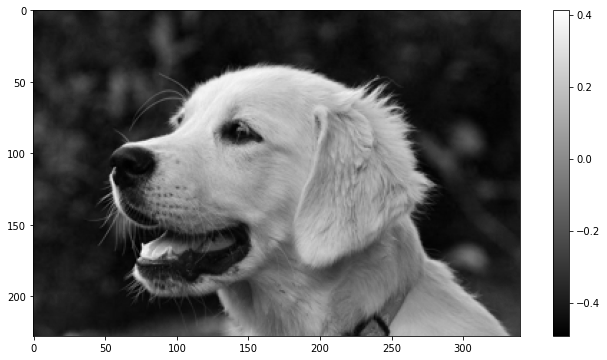

In [3]:
from PIL import Image
from matplotlib import pyplot as plt

img = Image.open("dog-2556796_960_720.jpg").resize((340,228))
img = np.array(img)[:,:,0].astype(np.float32)
img = img[:img.shape[1],:]/255. - 0.5
flat_img = jnp.reshape(img, (-1,))
img_shape = img.shape

plt.figure(figsize=(12,6))
plt.imshow(img, cmap="gray")
plt.colorbar()
plt.show()

#### Model details

The SIREN models doesn't output all image pixels at once, as often done in CV.

It instead borrows ideas from recent developements in machine learning for physics and classical spectral theory, by representing an image $I$ not as a discrete function of the pixels indexes, but rather as a continous function $I:\mathbb{R}^2 \to \mathbb{R}$. 

SIREN provides an approximation to such continous function by stacking together MLP layers with sinusoidal activation functions:

$$
I(x,y) \simeq b_0 + W_0\sin\left( b_1 + W_1 \sin\left(b_2 + W_2\sin(\dots)\right)\right)
$$


In [4]:
from fsiren import Siren, grid_init
from flax import optim

In [38]:
grid_dimension = img.shape
grid_dtype = img.dtype
grid = grid_init(grid_dimension, grid_dtype)()

In [39]:
grid.shape

(340, 228, 2)

In [7]:
from jax.nn import sigmoid

SirenDef = Siren(num_layers=5, output_dim=1, w0_first_layer=60.)

In [8]:
def mse_loss(output_im):
    return jnp.mean((output_im- img)**2)

In [9]:
def make_optimizer(params, learning_rate):
    optimizer = optim.Adam(learning_rate).create(params)
    return optimizer

In [10]:
def get_initial_params(key):
    return SirenDef.init(key, grid)["params"]

In [11]:
params = get_initial_params(rng)

In [14]:
@jax.jit
def train_step(optimizer):
    
    def loss_fn(params):
        output_im = SirenDef.apply({"params": params}, grid)[...,0].T
        loss = mse_loss(output_im)
        return loss, output_im
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    
    (loss, output_image), grad = grad_fn(optimizer.target)
    optimizer = optimizer.apply_gradient(grad)
    return optimizer, (loss, output_image)

In [15]:
optimizer = make_optimizer(params, learning_rate=0.0001)

In [16]:
num_steps = 10000

pbar = tqdm(total = num_steps)

for numstep in range(num_steps):
    optimizer, (lossval, output_image) = train_step(optimizer)
    pbar.set_description("Loss: {:01.8f}".format(lossval))
    pbar.update()
    
pbar.close()

Loss: 0.00025465: 100%|██████████| 10000/10000 [04:47<00:00, 34.73it/s]


In [40]:
a = SirenDef.apply({"params": optimizer.target}, grid)

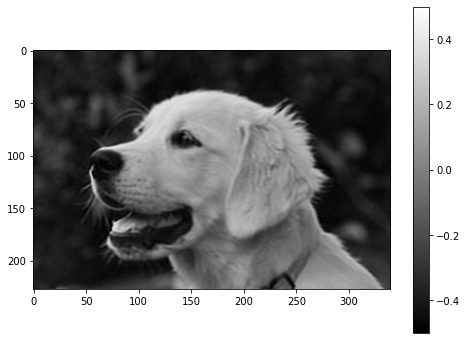

In [41]:
plt.figure(figsize=(8,6))
plt.imshow(a[...,0].T, vmin=-.5, vmax=.5, cmap="gray")
plt.colorbar()
plt.show()

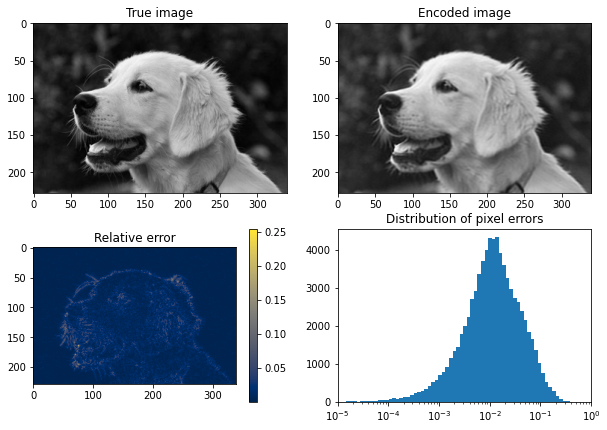

In [48]:
img_hat = a[...,0].T

fig, ax = plt.subplots(2,2, figsize=(10,7))

pcm = ax[0,0].imshow(img, cmap="gray")
ax[0,0].set_title("True image")

pcm = ax[0,1].imshow(img_hat, cmap="gray")
ax[0,1].set_title("Encoded image")

pcm = ax[1,0].imshow(jnp.abs(img - img_hat), cmap="cividis")
fig.colorbar(pcm, ax=ax[1,0])
ax[1,0].set_title("Relative error")

error = jnp.reshape(jnp.abs(img - img_hat)/jnp.amax(img), (-1,))
logbins = np.logspace(
    np.log10(jnp.amin(error)),
    np.log10(jnp.amax(error)),
    100
)
ax[1,1].hist(error, bins=logbins)
ax[1,1].set_xscale("log")
ax[1,1].set_title("Distribution of pixel errors")
ax[1,1].set_xlim([1e-5,1])

plt.savefig("results.png", facecolor="w")
plt.show()

## Upsampling

In [29]:
upsample_factor = 3
grid_dimension = [upsample_factor*x for x in img.shape]
grid_dtype = img.dtype
grid = grid_init(grid_dimension, grid_dtype)()

In [30]:
a = SirenDef.apply({"params": optimizer.target}, grid)

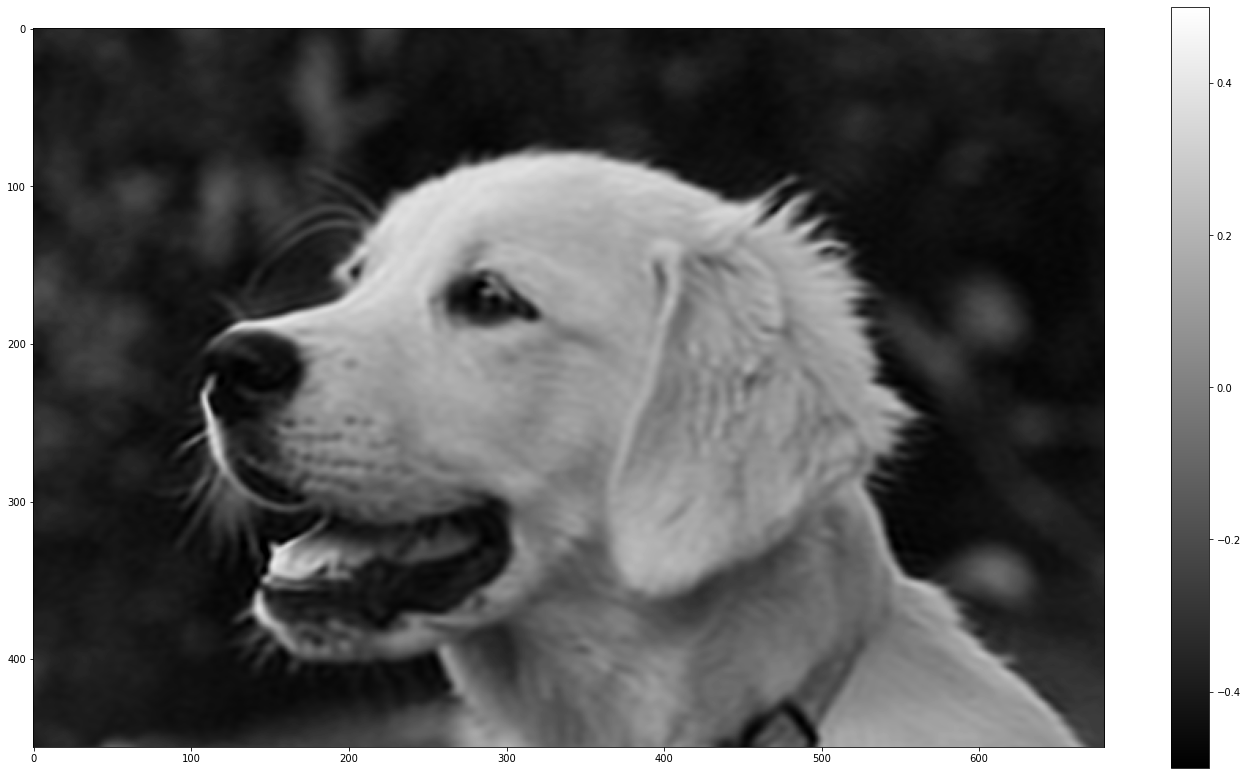

In [33]:
plt.figure(figsize=(24,14))
plt.imshow(a[...,0].T, vmin=-.5, vmax=.5, cmap="gray")
plt.colorbar()
plt.show()